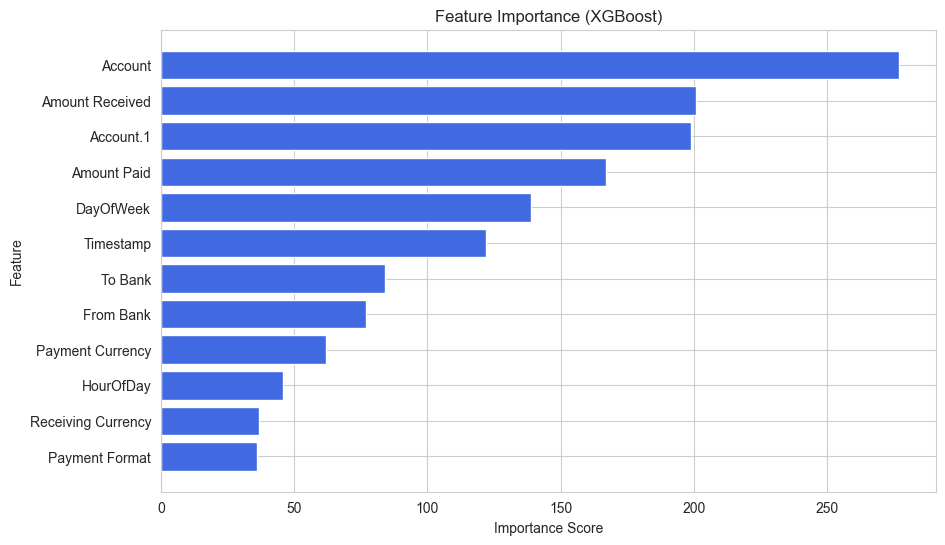

               Feature  Importance
2              Account       277.0
5      Amount Received       201.0
4            Account.1       199.0
7          Amount Paid       167.0
10           DayOfWeek       139.0
0            Timestamp       122.0
3              To Bank        84.0
1            From Bank        77.0
8     Payment Currency        62.0
11           HourOfDay        46.0
6   Receiving Currency        37.0
9       Payment Format        36.0


In [9]:
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, precision_recall_curve, auc
from catboost import CatBoostClassifier

# Load Dataset
file_path = "/Users/zoujingyi/Desktop/EDA/HI-Small_Trans.csv"
df = pd.read_csv(file_path)

import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Convert Timestamp to datetime and extract time-based features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['HourOfDay'] = df['Timestamp'].dt.hour  # Hour of the day (0-23)

# Identify categorical columns
categorical_cols = ['Account', 'Account.1', 'Payment Currency', 'From Bank', 'To Bank',
                    'Receiving Currency', 'Payment Format']

# Convert categorical columns to category codes
for col in categorical_cols:
    df[col] = df[col].astype('category').cat.codes


X = df.drop(columns=['Is Laundering'])  # Remove target variable
y = df['Is Laundering']  # Define target


# Convert Timestamp to Unix time
X['Timestamp'] = X['Timestamp'].astype(int) / 10**9

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

model = xgb.train(params, dtrain, num_boost_round=50)

# Extract feature importance
feature_importance = model.get_score(importance_type='weight')
feature_importance_df = pd.DataFrame({'Feature': feature_importance.keys(), 'Importance': feature_importance.values()})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

# Display feature importance scores
print(feature_importance_df)

# Permutation Feature Importance (Sklearn)

/Users/zoujingyi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:35:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


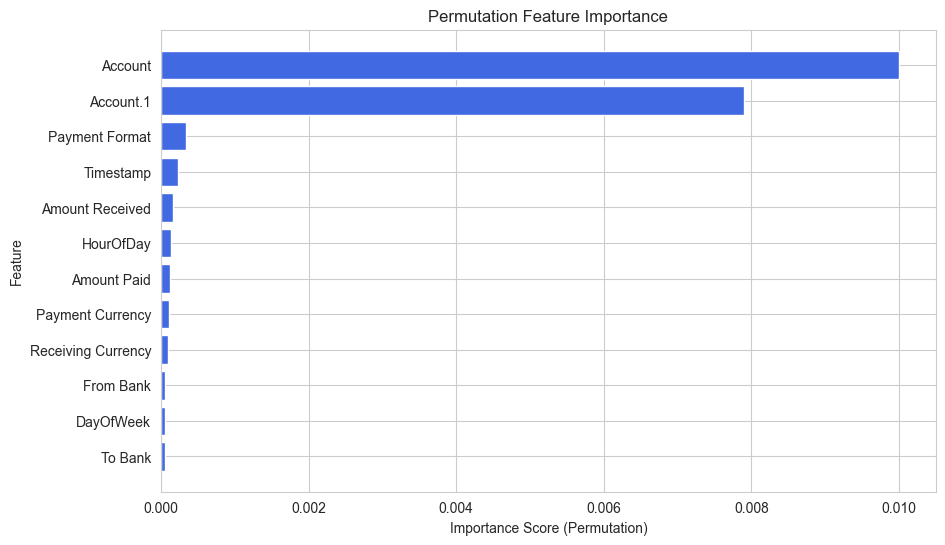

               Feature  Importance
2              Account    0.010001
4            Account.1    0.007906
9       Payment Format    0.000341
0            Timestamp    0.000231
5      Amount Received    0.000157
11           HourOfDay    0.000131
7          Amount Paid    0.000128
8     Payment Currency    0.000112
6   Receiving Currency    0.000098
1            From Bank    0.000060
10           DayOfWeek    0.000060
3              To Bank    0.000049


In [10]:
from sklearn.inspection import permutation_importance

# Train an XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False)
model.fit(X_train, y_train)

# Compute Permutation Feature Importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Sort and plot feature importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.xlabel('Importance Score (Permutation)')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Display scores
print(importance_df)

# SHAP (SHapley Additive exPlanations)

/Users/zoujingyi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:37:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
100%|===================| 1015196/1015669 [28:07<00:00]       

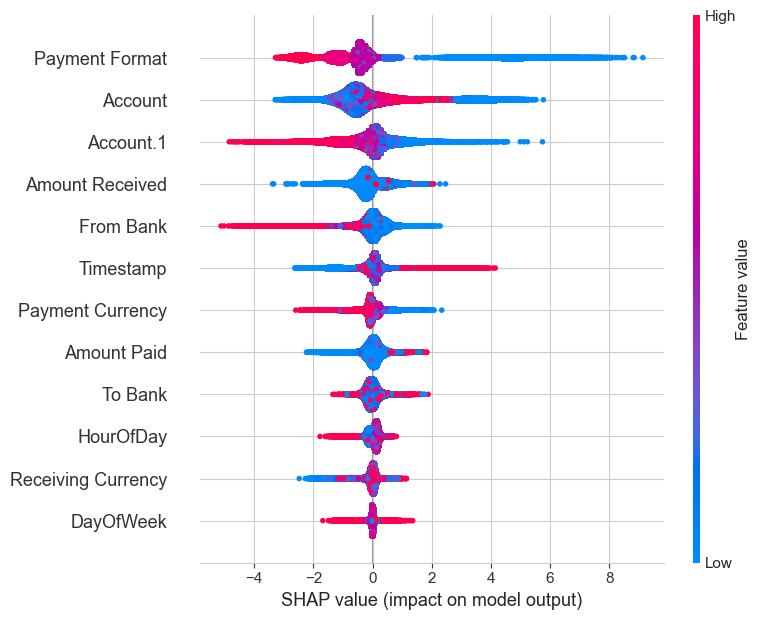

In [13]:
import shap

# Train an XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False)
model.fit(X_train, y_train)

# Compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test, check_additivity=False)  # Add this flag

# Plot global feature importance
shap.summary_plot(shap_values, X_test)


# Gain-Based Feature Importance

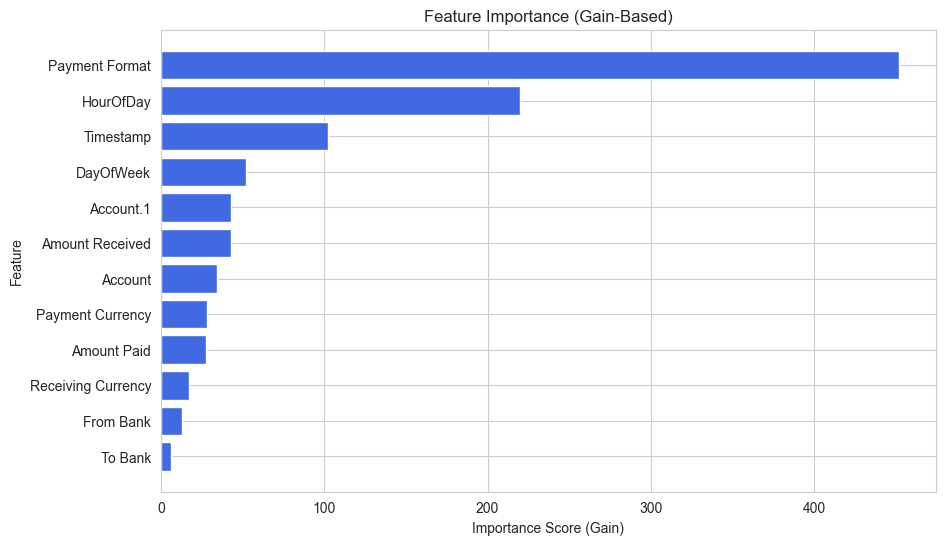

               Feature  Importance
9       Payment Format  451.834961
11           HourOfDay  220.014420
0            Timestamp  102.026176
10           DayOfWeek   52.212833
4            Account.1   43.199478
5      Amount Received   43.031372
2              Account   34.408630
8     Payment Currency   27.997608
7          Amount Paid   27.485617
6   Receiving Currency   17.149399
1            From Bank   12.663134
3              To Bank    6.250872


In [12]:
# Train XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
model = xgb.train(params, dtrain, num_boost_round=50)

# Extract Gain-based importance
importance_gain = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': importance_gain.keys(), 'Importance': importance_gain.values()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.xlabel('Importance Score (Gain)')
plt.ylabel('Feature')
plt.title('Feature Importance (Gain-Based)')
plt.gca().invert_yaxis()
plt.show()

print(importance_df)